In [1]:
#!/usr/bin/env python

# Ideal_MCSs_cases.ipynb

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
import geopandas as gpd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = np.radians(lat2-lat1)
    dlon = np.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(np.radians(lat1)) \
        * math.cos(np.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    import math
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


### Read in grid

In [2]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/SouthAmerica/MCS-Tracking/GPM/2001/merg_2001123110_4km-pixel.nc', mode='r')
Lat=np.squeeze(ncid.variables['lat'][:])
Lon=np.squeeze(ncid.variables['lon'][:])
ncid.close()
Lon,Lat = np.meshgrid(Lon,Lat)

In [3]:
lon = np.arange(0,15,0.1)
lat = np.arange(-10,10,0.1)
lon,lat = np.meshgrid(lon,lat)

### CASE1 - Three features that interact with each other

In [4]:
time_sections = [[0,7],
                [7,12],
                [12,19]] # time steps in hours

lat_dist = 3 # central distance between features at initiation
Tb_base = 240
Tb_overshoot = 215
tb_background = 300
maxsize = 250 # km radius

# pr characteristics
pr_rad = 0.6 # % of Tb radius
pr_min = 1 # mm/h
pr_max = 15 # mm/h

# DEFINE TRACKS
lat_featurs = np.zeros((time_sections[2][1], 3))
lon_featurs = np.zeros((time_sections[2][1], 3))

lat_featurs[:,0] = list([lat_dist] * (time_sections[1][1] - time_sections[0][0])) + \
        list(np.linspace(3,6,time_sections[2][1] - time_sections[2][0]))
lon_featurs[:,0] = np.linspace(5,10,time_sections[2][1] - time_sections[0][0])
 

lat_featurs[:,1] = list([0] * (time_sections[2][1] - time_sections[0][0]))
lon_featurs[:,1] = np.linspace(5,10,time_sections[2][1] - time_sections[0][0])

lat_featurs[:,2] = list([-lat_dist] * (time_sections[2][1] - time_sections[0][0]))
lon_featurs[:,2] = np.linspace(5,10,time_sections[2][1] - time_sections[0][0])

# DEFINE RADIAL SIZE OF CLOUD SHIELD
size_featurs = np.zeros((time_sections[2][1], 3))
size_featurs[:,0] = list(np.linspace(100,maxsize, (time_sections[0][1] - time_sections[0][0]))) + \
         list([maxsize] * (time_sections[2][1] - time_sections[1][0]))
size_featurs[:,1] = size_featurs[:,0]
size_featurs[:,2] = size_featurs[:,0]

In [5]:
# GENERATE THE MATRIX WITH THE ABOVE DESCRIBED FEATURES
tb_test = np.zeros((time_sections[2][1], lat.shape[0], lat.shape[1])); tb_test[:] = tb_background
pr_test = np.zeros((time_sections[2][1], lat.shape[0], lat.shape[1])); pr_test[:] = 0

for tt in range(size_featurs.shape[0]):
    for fe in range(size_featurs.shape[1]):
        rad_dist = haversine(lon_featurs[tt,fe], lat_featurs[tt,fe], lon, lat)
        
        # work on Tb
        tb_rad = rad_dist/size_featurs[tt,fe]
        tb_rad[tb_rad>1] = np.nan
        tb_rad = Tb_base - np.abs(tb_rad-1) * (Tb_base-Tb_overshoot) 
        
        tb_test[tt,tb_rad <= Tb_base] = tb_rad[tb_rad <= Tb_base]
        
        # Work on PR
        pr_tmp = rad_dist/(size_featurs[tt,fe]*pr_rad)
        pr_tmp[pr_tmp>1] = np.nan
        pr_tmp = pr_max - pr_tmp * (pr_max-pr_min) 
        
        pr_test[tt,pr_tmp >= pr_min] = pr_tmp[pr_tmp >= pr_min]

In [6]:
# plt.pcolormesh(lon,lat,mcs_test[16,:,:], cmap='gray_r', vmin = 215, vmax=300)

In [7]:
# plt.pcolormesh(lon,lat, pr_test[16,:,:], cmap='coolwarm', vmin = 0, vmax=15)

### Save data to netcdf

In [8]:
compress = False
print(' ')
print('Save the idealized MCS test case to a netcdf file')
# ============================
# Write NetCDF

dataset = Dataset('MCS-test-1_3-merging_1-splitting.nc','w',format='NETCDF4_CLASSIC')
yc = dataset.createDimension('yc', lat.shape[0])
xc = dataset.createDimension('xc', lon.shape[1])
time = dataset.createDimension('time', None)

times = dataset.createVariable('time', np.float64, ('time',))
LAT = dataset.createVariable('lat', np.float32, ('yc','xc',))
LON = dataset.createVariable('lon', np.float32, ('yc','xc',))
tb = dataset.createVariable('Tb', np.float32,('time','yc','xc'),zlib=compress)
pr = dataset.createVariable('PR', np.float32,('time','yc','xc'),zlib=compress)

times.calendar = "standard"
times.units = "hours since 2020-01-01 00:00:00"
times.standard_name = "time"
times.long_name = "time"

LAT.long_name = "latitude" ;
LAT.units = "degrees_north" ;
LAT.standard_name = "latitude" ;

LON.long_name = "longitude" ;
LON.units = "degrees_east" ;
LON.standard_name = "longitude" ;

pr.coordinates = "lon lat"
pr.long_name = "precipitation"
pr.units = 'mm/h'
tb.coordinates = "lon lat"
tb.long_name = "brightness temperature"
tb.units = 'K'

dataset.description = 'Idealized MCS to test tracking algorithms'
dataset.author = 'Andreas Prein'
dataset.email = 'prein@ucar.edu'

LAT[:] = lat
LON[:] = lon
pr[:] = pr_test
tb[:] = tb_test

times[:] = range(time_sections[2][1])

dataset.close()


 
Save the idealized MCS test case to a netcdf file


### CASE2 - Three features that interact with each other after living form > 4 hours

In [12]:
time_sections = [[0,4],
                 [4,10],
                [10,16],
                [16,26]] # time steps in hours

lat_dist = 3 # central distance between features at initiation
Tb_base = 240
Tb_overshoot = 215
tb_background = 300
maxsize = 250 # km radius

# pr characteristics
pr_rad = 0.6 # % of Tb radius
pr_min = 1 # mm/h
pr_max = 15 # mm/h

# DEFINE TRACKS
lat_featurs = np.zeros((time_sections[-1][1], 3))
lon_featurs = np.zeros((time_sections[-1][1], 3))

lat_featurs[:,0] = list([lat_dist] * (time_sections[1][1] - time_sections[0][0])) + \
        list(np.linspace(3,6,time_sections[-1][1] - time_sections[2][0]))
lon_featurs[:,0] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])
 

lat_featurs[:,1] = list([0] * (time_sections[-1][1] - time_sections[0][0]))
lon_featurs[:,1] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])

lat_featurs[:,2] = list([-lat_dist] * (time_sections[-1][1] - time_sections[0][0]))
lon_featurs[:,2] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])

# DEFINE RADIAL SIZE OF CLOUD SHIELD
size_featurs = np.zeros((time_sections[-1][1], 3))
size_featurs[:,0] = list([100]*time_sections[0][1]) + \
                    list(np.linspace(100,maxsize, (time_sections[1][1] - time_sections[1][0]))) + \
                    list([maxsize] * (time_sections[2][1] - time_sections[2][0])) + \
                    list([maxsize] * (time_sections[3][1] - time_sections[3][0]))
size_featurs[:,1] = size_featurs[:,0]
size_featurs[:,2] = size_featurs[:,0]



# GENERATE THE MATRIX WITH THE ABOVE DESCRIBED FEATURES
tb_test = np.zeros((time_sections[-1][1], lat.shape[0], lat.shape[1])); tb_test[:] = tb_background
pr_test = np.zeros((time_sections[-1][1], lat.shape[0], lat.shape[1])); pr_test[:] = 0

for tt in range(size_featurs.shape[0]):
    for fe in range(size_featurs.shape[1]):
        rad_dist = haversine(lon_featurs[tt,fe], lat_featurs[tt,fe], lon, lat)
        
        # work on Tb
        tb_rad = rad_dist/size_featurs[tt,fe]
        tb_rad[tb_rad>1] = np.nan
        tb_rad = Tb_base - np.abs(tb_rad-1) * (Tb_base-Tb_overshoot)
        
        tb_test[tt,tb_rad <= Tb_base] = tb_rad[tb_rad <= Tb_base]
        
        # Work on PR
        pr_tmp = rad_dist/(size_featurs[tt,fe]*pr_rad)
        pr_tmp[pr_tmp>1] = np.nan
        pr_tmp = pr_max - pr_tmp * (pr_max-pr_min) 
        
        pr_test[tt,pr_tmp >= pr_min] = pr_tmp[pr_tmp >= pr_min]
        
        


compress = False
print(' ')
print('Save the idealized MCS test case to a netcdf file')
# ============================
# Write NetCDF

dataset = Dataset('MCS-test-2_3-merging_1-splitting_longer-isolation.nc','w',format='NETCDF4_CLASSIC')
yc = dataset.createDimension('yc', lat.shape[0])
xc = dataset.createDimension('xc', lon.shape[1])
time = dataset.createDimension('time', None)

times = dataset.createVariable('time', np.float64, ('time',))
LAT = dataset.createVariable('lat', np.float32, ('yc','xc',))
LON = dataset.createVariable('lon', np.float32, ('yc','xc',))
tb = dataset.createVariable('Tb', np.float32,('time','yc','xc'),zlib=compress)
pr = dataset.createVariable('PR', np.float32,('time','yc','xc'),zlib=compress)

times.calendar = "standard"
times.units = "hours since 2020-01-01 00:00:00"
times.standard_name = "time"
times.long_name = "time"

LAT.long_name = "latitude" ;
LAT.units = "degrees_north" ;
LAT.standard_name = "latitude" ;

LON.long_name = "longitude" ;
LON.units = "degrees_east" ;
LON.standard_name = "longitude" ;

pr.coordinates = "lon lat"
pr.long_name = "precipitation"
pr.units = 'mm/h'
tb.coordinates = "lon lat"
tb.long_name = "brightness temperature"
tb.units = 'K'

dataset.description = 'Idealized MCS to test tracking algorithms'
dataset.author = 'Andreas Prein'
dataset.email = 'prein@ucar.edu'

LAT[:] = lat
LON[:] = lon
pr[:] = pr_test
tb[:] = tb_test

times[:] = range(pr_test.shape[0])

dataset.close()


 
Save the idealized MCS test case to a netcdf file


### CASE3 - Similar to case 2 but only the center system retains an overshoot

In [20]:
time_sections = [[0,4],
                 [4,10],
                [10,16],
                [16,26]] # time steps in hours

lat_dist = 3 # central distance between features at initiation
Tb_base = 240
Tb_overshoot = 215
Tb_overshoot_dieback = 230
tb_background = 300
maxsize = 250 # km radius

tb_development = list([Tb_overshoot] * 6) + \
                 list(np.linspace(Tb_overshoot, Tb_overshoot_dieback, 4)) + \
                 list([Tb_overshoot_dieback] * 16)

# pr characteristics
pr_rad = 0.6 # % of Tb radius
pr_min = 1 # mm/h
pr_max = 15 # mm/h

# DEFINE TRACKS
lat_featurs = np.zeros((time_sections[-1][1], 3))
lon_featurs = np.zeros((time_sections[-1][1], 3))

lat_featurs[:,0] = list([lat_dist] * (time_sections[1][1] - time_sections[0][0])) + \
        list(np.linspace(3,6,time_sections[-1][1] - time_sections[2][0]))
lon_featurs[:,0] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])
 

lat_featurs[:,1] = list([0] * (time_sections[-1][1] - time_sections[0][0]))
lon_featurs[:,1] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])

lat_featurs[:,2] = list([-lat_dist] * (time_sections[-1][1] - time_sections[0][0]))
lon_featurs[:,2] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])

# DEFINE RADIAL SIZE OF CLOUD SHIELD
size_featurs = np.zeros((time_sections[-1][1], 3))
size_featurs[:,0] = list([100]*time_sections[0][1]) + \
                    list(np.linspace(100,maxsize, (time_sections[1][1] - time_sections[1][0]))) + \
                    list([maxsize] * (time_sections[2][1] - time_sections[2][0])) + \
                    list([maxsize] * (time_sections[3][1] - time_sections[3][0]))
size_featurs[:,1] = size_featurs[:,0]
size_featurs[:,2] = size_featurs[:,0]



# GENERATE THE MATRIX WITH THE ABOVE DESCRIBED FEATURES
tb_test = np.zeros((time_sections[-1][1], lat.shape[0], lat.shape[1])); tb_test[:] = tb_background
pr_test = np.zeros((time_sections[-1][1], lat.shape[0], lat.shape[1])); pr_test[:] = 0

for tt in range(size_featurs.shape[0]):
    for fe in range(size_featurs.shape[1]):
        rad_dist = haversine(lon_featurs[tt,fe], lat_featurs[tt,fe], lon, lat)
        
        # work on Tb
        tb_rad = rad_dist/size_featurs[tt,fe]
        tb_rad[tb_rad>1] = np.nan
        if fe == 1:
            tb_rad = Tb_base - np.abs(tb_rad-1) * (Tb_base-Tb_overshoot) 
        else:
            tb_rad = Tb_base - np.abs(tb_rad-1) * (Tb_base-tb_development[tt]) 
        
        tb_test[tt,tb_rad <= Tb_base] = tb_rad[tb_rad <= Tb_base]
        
        # Work on PR
        pr_tmp = rad_dist/(size_featurs[tt,fe]*pr_rad)
        pr_tmp[pr_tmp>1] = np.nan
        pr_tmp = pr_max - pr_tmp * (pr_max-pr_min) 
        
        pr_test[tt,pr_tmp >= pr_min] = pr_tmp[pr_tmp >= pr_min]
        
        


compress = False
print(' ')
print('Save the idealized MCS test case to a netcdf file')
# ============================
# Write NetCDF

dataset = Dataset('MCS-test-3_3-merging_1-splitting_longer-isolation_single-overshoot.nc','w',format='NETCDF4_CLASSIC')
yc = dataset.createDimension('yc', lat.shape[0])
xc = dataset.createDimension('xc', lon.shape[1])
time = dataset.createDimension('time', None)

times = dataset.createVariable('time', np.float64, ('time',))
LAT = dataset.createVariable('lat', np.float32, ('yc','xc',))
LON = dataset.createVariable('lon', np.float32, ('yc','xc',))
tb = dataset.createVariable('Tb', np.float32,('time','yc','xc'),zlib=compress)
pr = dataset.createVariable('PR', np.float32,('time','yc','xc'),zlib=compress)

times.calendar = "standard"
times.units = "hours since 2020-01-01 00:00:00"
times.standard_name = "time"
times.long_name = "time"

LAT.long_name = "latitude" ;
LAT.units = "degrees_north" ;
LAT.standard_name = "latitude" ;

LON.long_name = "longitude" ;
LON.units = "degrees_east" ;
LON.standard_name = "longitude" ;

pr.coordinates = "lon lat"
pr.long_name = "precipitation"
pr.units = 'mm/h'
tb.coordinates = "lon lat"
tb.long_name = "brightness temperature"
tb.units = 'K'

dataset.description = 'Idealized MCS to test tracking algorithms'
dataset.author = 'Andreas Prein'
dataset.email = 'prein@ucar.edu'

LAT[:] = lat
LON[:] = lon
pr[:] = pr_test
tb[:] = tb_test

times[:] = range(pr_test.shape[0])

dataset.close()


 
Save the idealized MCS test case to a netcdf file


### CASE4 - Systems develop a-synchronus

In [22]:
dev_func = np.cos(np.linspace(-np.pi/2, np.pi/2, 12))

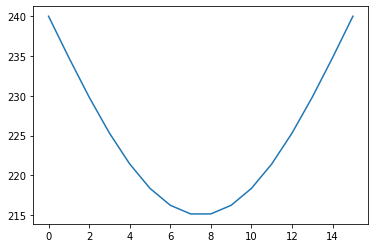

In [106]:
plt.plot(list(Tb_base - (dev_func * (Tb_base - Tb_overshoot))))

In [16]:
time_sections = [[0,4],
                 [4,10],
                [10,16],
                [16,26]] # time steps in hours

lat_dist = 3 # central distance between features at initiation
Tb_base = 240
Tb_overshoot = 215
Tb_overshoot_dieback = 230
tb_background = 300
maxsize = 250 # km radius

dev_func = np.cos(np.linspace(-np.pi/2, np.pi/2, 16))

tb_development_1 = list(Tb_base - (dev_func * (Tb_base - Tb_overshoot))) + \
                    list([tb_background] * 10)
tb_development_2 = list([tb_background] * 5)+ \
                   list(Tb_base - (dev_func * (Tb_base - Tb_overshoot))) + \
                    list([tb_background] * 5)
tb_development_3 = list([tb_background] * 10) + \
                    list(Tb_base - (dev_func * (Tb_base - Tb_overshoot)))
tb_development = [tb_development_1, tb_development_2, tb_development_3]


tb_size_dev_1 = list((dev_func * maxsize)) + \
                    list([0] * 10)
tb_size_dev_2 = list([0] * 5) + \
                    list((dev_func * maxsize)) + \
                    list([0] * 5)
tb_size_dev_3 = list([0] * 10) + \
                     list((dev_func * maxsize))
tb_size_dev =  [tb_size_dev_1, tb_size_dev_2, tb_size_dev_3]

# pr characteristics
pr_rad = 0.6 # % of Tb radius
pr_min = 1 # mm/h
pr_max = 15 # mm/h
                          
pr_size_dev_1 = list(np.array(tb_size_dev_1) * pr_rad)
pr_size_dev_2 = list(np.array(tb_size_dev_2) * pr_rad)
pr_size_dev_3 = list(np.array(tb_size_dev_3) * pr_rad)
pr_size_dev = [pr_size_dev_1, pr_size_dev_2, pr_size_dev_3]
                          

# DEFINE TRACKS
lat_featurs = np.zeros((time_sections[-1][1], 3))
lon_featurs = np.zeros((time_sections[-1][1], 3))

lat_featurs[:,0] = list([lat_dist] * (time_sections[1][1] - time_sections[0][0])) + \
        list(np.linspace(3,6,time_sections[-1][1] - time_sections[2][0]))
lon_featurs[:,0] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])
 

lat_featurs[:,1] = list([0] * (time_sections[-1][1] - time_sections[0][0]))
lon_featurs[:,1] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])

lat_featurs[:,2] = list([-lat_dist] * (time_sections[-1][1] - time_sections[0][0]))
lon_featurs[:,2] = np.linspace(5,10,time_sections[-1][1] - time_sections[0][0])

# DEFINE RADIAL SIZE OF CLOUD SHIELD
size_featurs = np.zeros((time_sections[-1][1], 3))
size_featurs[:,0] = list([100]*time_sections[0][1]) + \
                    list(np.linspace(100,maxsize, (time_sections[1][1] - time_sections[1][0]))) + \
                    list([maxsize] * (time_sections[2][1] - time_sections[2][0])) + \
                    list([maxsize] * (time_sections[3][1] - time_sections[3][0]))
size_featurs[:,1] = size_featurs[:,0]
size_featurs[:,2] = size_featurs[:,0]



# GENERATE THE MATRIX WITH THE ABOVE DESCRIBED FEATURES
tb_test = np.zeros((time_sections[-1][1], lat.shape[0], lat.shape[1])); tb_test[:] = tb_background
pr_test = np.zeros((time_sections[-1][1], lat.shape[0], lat.shape[1])); pr_test[:] = 0

for tt in range(size_featurs.shape[0]):
    for fe in range(size_featurs.shape[1]):
        rad_dist = haversine(lon_featurs[tt,fe], lat_featurs[tt,fe], lon, lat)
        
        # work on Tb
        tb_rad = rad_dist/tb_size_dev[fe][tt]
        tb_rad[tb_rad>1] = np.nan
        tb_rad = Tb_base - np.abs(tb_rad-1) * (Tb_base-tb_development[fe][tt]) 
        
        if np.sum(~np.isnan(tb_rad)) > 0:
            tb_test[tt,~np.isnan(tb_rad)] = tb_rad[~np.isnan(tb_rad)]
        
            # Work on PR
            pr_tmp = rad_dist/(pr_size_dev[fe][tt])
            pr_tmp[pr_tmp>1] = np.nan
            pr_tmp = pr_max - pr_tmp * (pr_max-pr_min) 
        
            pr_test[tt,pr_tmp >= pr_min] = pr_tmp[pr_tmp >= pr_min]
        
        


compress = False
print(' ')
print('Save the idealized MCS test case to a netcdf file')
# ============================
# Write NetCDF

dataset = Dataset('MCS-test-4_asynchronous-development.nc','w',format='NETCDF4_CLASSIC')
yc = dataset.createDimension('yc', lat.shape[0])
xc = dataset.createDimension('xc', lon.shape[1])
time = dataset.createDimension('time', None)

times = dataset.createVariable('time', np.float64, ('time',))
LAT = dataset.createVariable('lat', np.float32, ('yc','xc',))
LON = dataset.createVariable('lon', np.float32, ('yc','xc',))
tb = dataset.createVariable('Tb', np.float32,('time','yc','xc'),zlib=compress)
pr = dataset.createVariable('PR', np.float32,('time','yc','xc'),zlib=compress)

times.calendar = "standard"
times.units = "hours since 2020-01-01 00:00:00"
times.standard_name = "time"
times.long_name = "time"

LAT.long_name = "latitude" ;
LAT.units = "degrees_north" ;
LAT.standard_name = "latitude" ;

LON.long_name = "longitude" ;
LON.units = "degrees_east" ;
LON.standard_name = "longitude" ;

pr.coordinates = "lon lat"
pr.long_name = "precipitation"
pr.units = 'mm/h'
tb.coordinates = "lon lat"
tb.long_name = "brightness temperature"
tb.units = 'K'

dataset.description = 'Idealized MCS to test tracking algorithms'
dataset.author = 'Andreas Prein'
dataset.email = 'prein@ucar.edu'

LAT[:] = lat
LON[:] = lon
pr[:] = pr_test
tb[:] = tb_test

times[:] = range(pr_test.shape[0])

dataset.close()


 
Save the idealized MCS test case to a netcdf file
